In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import f1_score

from preprocess.preprocess_transaction_frequecy import preprocess_transaction_frequency
from preprocess.preprocess_init import preprocess_init
from preprocess.preprocess_time import preprocess_time
from preprocess.preprocess_change_card import preprocess_change_card
from preprocess.preprocess_mchno import preprocess_mchno
from preprocess.preprocess_special_features import preprocess_special_features
from preprocess.preprocess_conam import preprocess_conam
from preprocess.preprocess_train_test_split import preprocess_train_test_split
from preprocess.preprocess_rolling_features import preprocess_rolling_features


from util.generate_X_y import generate_X_y
from util.remove_outlier import remove_outlier
from util.generate_statistic import generate_statistic

from model.lgbm_model import  LGBM_Model 
from model.shap_importance import shap_importance
from model.plot import plot_importance

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [2]:
# pandas==0.25.1
# matplotlib==3.1.1
# scikit_learn==0.21.3
# pandas==0.25.1
# lightgbm==2.2.3
# shap==0.32.0
# joblib==0.13.2
# seaborn==0.9.0
# jupyter==1.0.0

# Model Explanation

- Total: 5 models

- Base model: Created by base features which contain 20 raw features and 13 preprocessed features.

- Special features: 4 special features to capture the information of the label, since there are some users(bacno) in both training and testing set.

- Each of the four models is trained by the base features plus one special feature.

- If the transaction in testing meets the conditions of special features, the transaction is predicted by the corresponding special model. Otherwise the transaction is predicted by the base model.

- Note: These special features may not work in real world since we don't suppose have the label.

# Define features

These are the features i used in the model

In [2]:
raw_bool_features = ['ecfg',
                     'flbmk',
                     'flg_3dsmk',
                     'insfg',
                     'ovrlt'
                      ]

raw_categorial_features = ['contp',
                           'stscd',
                           'etymd',
                           'stocn',
                           'mcc',
                           'csmcu',
                           'hcefg',
                           'bacno',
                           'cano',
                           'mchno',
                           'acqic',
                           'scity'
                            ] 

raw_contiuous_feautres = ['loctm',
                          'conam',
                          'iterm'
                           ]

transaction_frequency_feautres = ['cano_days_txkey_count',#同卡號，同一週期(30/60/90)出現的次數
                                  'cano_locdt_txkey_count',#同卡號，同一天出現的次數
                                  'bacno_locdt_mchno_txkey_count'#同帳號，同一天，同特店出現的次數
                                    ]

time_feautres = ['last_time_days',
                 'next_time_days',
                 'cano_locdt_global_time_std' 
                    ]


change_card_feautres = ['diff_locdt_with_last_trans_cano',
                        'diff_locdt_of_two_card'
                           ]

conam_feautres = ['cano_locdt_conam_min',
                  'cano_locdt_conam_max',
                  'diff_gtime_with_conam_zero_trans_locdt'
                   ]

mchno_features = ['bacno_mchno_locdt_head_tail_diff',
                  'cano_days_mchno_index',    
                    ]

rolling_features = ['bacno_cano_stocn_unique_6h',
                    'bacno_cano_stocn_unique_7d', 
                    'bacno_cano_mchno_unique_6h',
                    'bacno_cano_mchno_unique_7d', 
                    'bacno_cano_mcc_unique_6h',
                    'bacno_cano_mcc_unique_7d', 
                    'bacno_cano_conam_mean_6h',
                    'bacno_cano_conam_sum_6h', 
                    'bacno_cano_conam_mean_7d',
                    'bacno_cano_conam_sum_7d']

special_feautures = ['mchno_in_normal_mchno_list',# 這間特電在過去的交易中有出現且是正常的
                    'mchno_in_fraud_mchno_list',# 這間特電在過去的交易中有出現且是盜刷的
                    'conam_in_fraud_conam_list',# 金額在過去的交易中有出現且是異常的
                    'diff_with_first_fraud_locdt'#與該卡號第一次被判盜刷距今的交易時間 
                               ]

base_features =  (    raw_bool_features 
                    + raw_categorial_features
                    + raw_contiuous_feautres
                    + transaction_frequency_feautres
                    + time_feautres
                    + change_card_feautres
                    + conam_feautres 
                    + mchno_features
                    + rolling_features
                       )

label = 'fraud_ind'

# Preprocess

In [5]:
preprocess_group = False
if preprocess_group:
    df_train_raw = pd.read_csv('data/train.csv')
    df_test_raw = pd.read_csv('data/test.csv')
    df = preprocess_init(df_train_raw, df_test_raw, raw_bool_features)
    df = preprocess_transaction_frequency(df)
    df = preprocess_time(df)
    df = preprocess_change_card(df)
    df = preprocess_mchno(df)
    df = preprocess_conam(df)
    df = preprocess_rolling_features(df)
    df = preprocess_special_features(df)
    df.to_pickle('data/df_preprocessed.pkl')
else:
    df = pd.read_pickle('data/df_preprocessed.pkl')    

# Base features

In [6]:
df_train, df_test = preprocess_train_test_split(df, raw_categorial_features)# Replace the value of categorical features of training
                                                                                #set with NA 
                                                                                #if the value is not in testing set
input_features = base_features 
X_train, y_train, groups, X_test = generate_X_y(df_train, df_test, label, input_features)
X_train.tail(10)

ecfg  flbmk  flg_3dsmk  insfg  ovrlt contp stscd etymd  stocn    mcc  \
1943429     0      0          0      0      0   5.0   0.0   5.0  102.0  292.0   
1943430     1      0          0      0      0   5.0   0.0   8.0  102.0  209.0   
1943431     0      0          0      0      0   5.0   0.0   5.0  102.0  270.0   
1943432     0      0          0      0      0   5.0   0.0   5.0  102.0  306.0   
1943433     0      0          0      0      0   5.0   0.0   5.0  102.0  192.0   
1943434     0      0          0      0      0   5.0   0.0   5.0  102.0  288.0   
1943435     0      0          0      0      0   5.0   0.0   5.0  102.0  247.0   
1943436     0      0          0      0      0   5.0   0.0   5.0  102.0  247.0   
1943437     0      0          0      0      0   5.0   0.0   5.0  102.0  247.0   
1943438     1      0          0      1      0   5.0   0.0   8.0  102.0  247.0   

        csmcu hcefg bacno cano  mchno   acqic   scity     loctm    conam  \
1943429  62.0   5.0   NaN  NaN  47022  6716.0  4526.0  202808.0   815.08   
1943430  62.0   5.0   NaN  NaN  38207  6322.0  5817.0   61702.0   750.24   
1943431  62.0   5.0   NaN  NaN  39044  6716.0  5820.0  191457.0   841.64   
1943432  62.0   5.0   NaN  NaN  88672  5975.0  5817.0  212337.0   381.65   
1943433  62.0   5.0   NaN  NaN    NaN  5975.0  5817.0  205657.0   366.38   
1943434  62.0   5.0   NaN  NaN    NaN  5975.0  5817.0  155256.0  1119.11   
1943435  62.0   5.0   NaN  NaN   6475  6767.0  5817.0  172203.0  1334.91   
1943436  62.0   5.0   NaN  NaN   6475  6767.0  5817.0  175548.0  1125.71   
1943437  62.0   5.0   NaN  NaN   6475  6767.0  5817.0  180803.0  1103.64   
1943438  62.0   5.0   NaN  NaN  82174  6769.0  5817.0  101612.0  1194.66   

         iterm  cano_days_txkey_count  cano_locdt_txkey_count  \
1943429      0                      9                       1   
1943430      0                      9                       3   
1943431      0                      9                       3   
1943432      0                      9                       3   
1943433      0                      9                       1   
1943434      0                      9                       4   
1943435      0                      9                       4   
1943436      0                      9                       4   
1943437      0                      9                       4   
1943438      1                      9                       1   

         bacno_locdt_mchno_txkey_count  last_time_days  next_time_days  \
1943429                              1         99046.0             NaN   
1943430                              1             NaN        -46675.0   
1943431                              1         46675.0         -7720.0   
1943432                              1          7720.0        -84800.0   
1943433                              1         84800.0       -240959.0   
1943434                              1        240959.0         -5347.0   
1943435                              3          5347.0         -2025.0   
1943436                              3          2025.0          -735.0   
1943437                              3           735.0       -749289.0   
1943438                              1        749289.0             NaN   

         cano_locdt_global_time_std  diff_locdt_with_last_trans_cano  \
1943429                         NaN                                0   
1943430                29430.624781                              -13   
1943431                29430.624781                              -13   
1943432                29430.624781                              -13   
1943433                         NaN                              -12   
1943434                 3661.951802                               -9   
1943435                 3661.951802                               -9   
1943436                 3661.951802                               -9   
1943437                 3661.951802                               -9   
1943438                      

# Find customers exist both in training and testing sets 

In [7]:
test_bacno = df_test['bacno'].tolist()
train_bacno = df_train['bacno_original'].tolist()

In [8]:
both_in_train_test = list( set( df_train[df_train['bacno_original'].isin(test_bacno)]['bacno_original'].tolist() ))

In [9]:
both_in_train_test[:5]

[131074, 98312, 73737, 65550, 106511]

In [10]:
check = 65550
print(df_test[df_test['bacno']==check][['bacno']].head(2))
print(df_train[df_train['bacno_original']==check][['bacno_original']].head(2))

        bacno
776749  65550
776750  65550
        bacno_original
776746           65550
776747           65550


# Base Model

In [11]:
lgbm = LGBM_Model(input_features) #等這跑完
oof_preds_LGBM, df_sub_preds_LGBM, clf = lgbm.run(X_train, y_train, groups, X_test,
                                                  lgbm.lgbm_averge_precision, n_splits = 5
                                                 ,  model_name='base_model')

Starting LightGBM. Fold 1,Train shape: (1521787, 43), test shape: (421665, 43)
Training until validation scores don't improve for 100 rounds.
[100]	training's Averge Precision: 0.805569	valid_1's Averge Precision: 0.673559
[200]	training's Averge Precision: 0.845485	valid_1's Averge Precision: 0.693337
[300]	training's Averge Precision: 0.870209	valid_1's Averge Precision: 0.70132
[400]	training's Averge Precision: 0.887681	valid_1's Averge Precision: 0.707512
[500]	training's Averge Precision: 0.900043	valid_1's Averge Precision: 0.711566
[600]	training's Averge Precision: 0.910291	valid_1's Averge Precision: 0.713329
[700]	training's Averge Precision: 0.918425	valid_1's Averge Precision: 0.715757
[800]	training's Averge Precision: 0.925251	valid_1's Averge Precision: 0.717386
[900]	training's Averge Precision: 0.931311	valid_1's Averge Precision: 0.719702
[1000]	training's Averge Precision: 0.936149	valid_1's Averge Precision: 0.719828
Did not meet early stopping. Best iteration is:


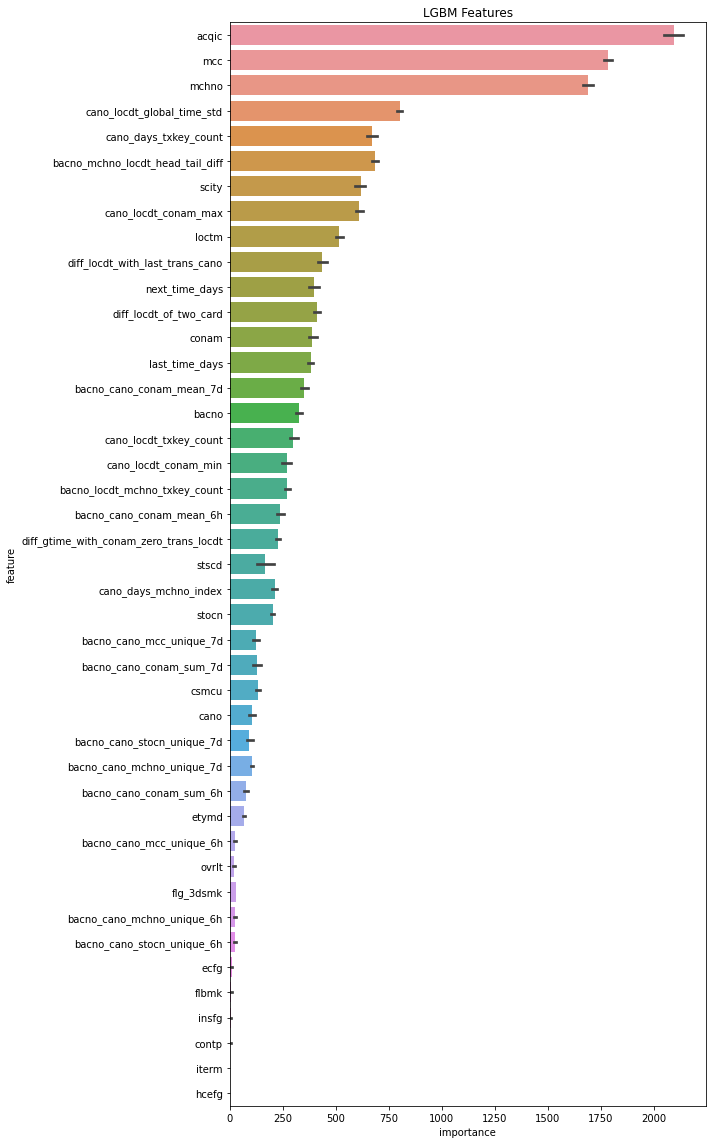

In [12]:
plot_importance(lgbm.df_feature_importance)

In [13]:
df_sub_preds_statistics = generate_statistic(df_sub_preds_LGBM)
df_sub_preds_statistics.head()

fold_0    fold_1    fold_2    fold_3    fold_4       max       min  \
0  0.000019  0.000013  0.000004  0.000014  0.000007  0.000019  0.000004   
1  0.000004  0.000128  0.000035  0.000071  0.000006  0.000128  0.000004   
2  0.000062  0.000048  0.000150  0.000052  0.000037  0.000150  0.000037   
3  0.000014  0.000010  0.000020  0.000017  0.000024  0.000024  0.000010   
4  0.000002  0.000003  0.000002  0.000002  0.000002  0.000003  0.000002   

            std      mean  upper_bound_1std  lower_bound_1std  
0  5.273274e-06  0.000012          0.000017          0.000006  
1  4.666115e-05  0.000049          0.000096          0.000002  
2  4.086741e-05  0.000070          0.000111          0.000029  
3  4.681168e-06  0.000017          0.000022          0.000012  
4  6.590215e-07  0.000002          0.000003          0.000001

In [14]:
df_sub_preds_statistics[df_sub_preds_statistics['max'] - df_sub_preds_statistics['min']>0.9].head(10)

fold_0    fold_1    fold_2    fold_3    fold_4       max       min  \
4383   0.997903  0.212113  0.993429  0.992887  0.087975  0.997903  0.087975   
4717   0.896991  0.981175  0.875408  0.919639  0.030217  0.981175  0.030217   
13550  0.956317  0.950510  0.018239  0.947786  0.945117  0.956317  0.018239   
39743  0.920978  0.074527  0.977035  0.082149  0.069057  0.977035  0.069057   
42706  0.998125  0.067137  0.981658  0.995016  0.999287  0.999287  0.067137   
53826  0.935310  0.829482  0.003519  0.876011  0.876470  0.935310  0.003519   
53827  0.938238  0.878781  0.002721  0.891072  0.871461  0.938238  0.002721   
53828  0.949117  0.867349  0.003761  0.901940  0.881789  0.949117  0.003761   
53829  0.942801  0.847764  0.004147  0.912388  0.883684  0.942801  0.004147   
53830  0.952018  0.892562  0.003987  0.904122  0.871830  0.952018  0.003987   

            std      mean  upper_bound_1std  lower_bound_1std  
4383   0.415676  0.656862          1.072538          0.241185  
4717   0.356989  0.740686          1.097675          0.383697  
13550  0.372696  0.763594          1.136290          0.390898  
39743  0.428442  0.424749          0.853191         -0.003692  
42706  0.370607  0.808244          1.178851          0.437638  
53826  0.351925  0.704158          1.056084          0.352233  
53827  0.357623  0.716455          1.074078          0.358831  
53828  0.359578  0.720791          1.080369          0.361214  
53829  0.358385  0.718157          1.076542          0.359772  
53830  0.361419  0.724904          1.086323          0.363485

# Remove Outier

Since some of the predictions above are very extreme, i drop it if the prediction is out of 1 standard deviation boundary.

In [15]:
df_sub_preds_statistics['mean_remove_outlier'] = df_sub_preds_statistics.apply(remove_outlier, axis = 1)
df_sub_preds_statistics[df_sub_preds_statistics['max'] - df_sub_preds_statistics['min']>0.9][['mean','mean_remove_outlier']].head(10)

mean  mean_remove_outlier
4383   0.656862             0.842443
4717   0.740686             0.899179
13550  0.763594             0.919940
39743  0.424749             0.191330
42706  0.808244             0.963603
53826  0.704158             0.859457
53827  0.716455             0.872374
53828  0.720791             0.878351
53829  0.718157             0.874599
53830  0.724904             0.882909

In [16]:
df_train['oof_base_model'] = oof_preds_LGBM
df_test.reset_index(drop=True,inplace=True)
df_test['sub_base_model'] = df_sub_preds_statistics['mean_remove_outlier']

# Special Model - Both exist in training and testing sets 

In [17]:
input_features = base_features + special_feautures
X_train, y_train, groups, X_test = generate_X_y(df_train, df_test, label, input_features)

In [18]:
lgbm = LGBM_Model(input_features)
oof_preds_LGBM, df_sub_preds_LGBM, clf = lgbm.run(X_train, y_train, groups, X_test, lgbm.lgbm_averge_precision, n_splits = 10 
                                                 , model_name='Both_exist')

Starting LightGBM. Fold 1,Train shape: (1521787, 47), test shape: (421665, 47)
Training until validation scores don't improve for 100 rounds.
[100]	training's Averge Precision: 0.846854	valid_1's Averge Precision: 0.777699
[200]	training's Averge Precision: 0.88081	valid_1's Averge Precision: 0.783097
[300]	training's Averge Precision: 0.899672	valid_1's Averge Precision: 0.786952
Early stopping, best iteration is:
[250]	training's Averge Precision: 0.891317	valid_1's Averge Precision: 0.787797
Starting LightGBM. Fold 2,Train shape: (1521787, 47), test shape: (421665, 47)
Training until validation scores don't improve for 100 rounds.
[100]	training's Averge Precision: 0.848241	valid_1's Averge Precision: 0.779512
[200]	training's Averge Precision: 0.881299	valid_1's Averge Precision: 0.794955
[300]	training's Averge Precision: 0.900144	valid_1's Averge Precision: 0.799185
[400]	training's Averge Precision: 0.913143	valid_1's Averge Precision: 0.800745
[500]	training's Averge Precision:

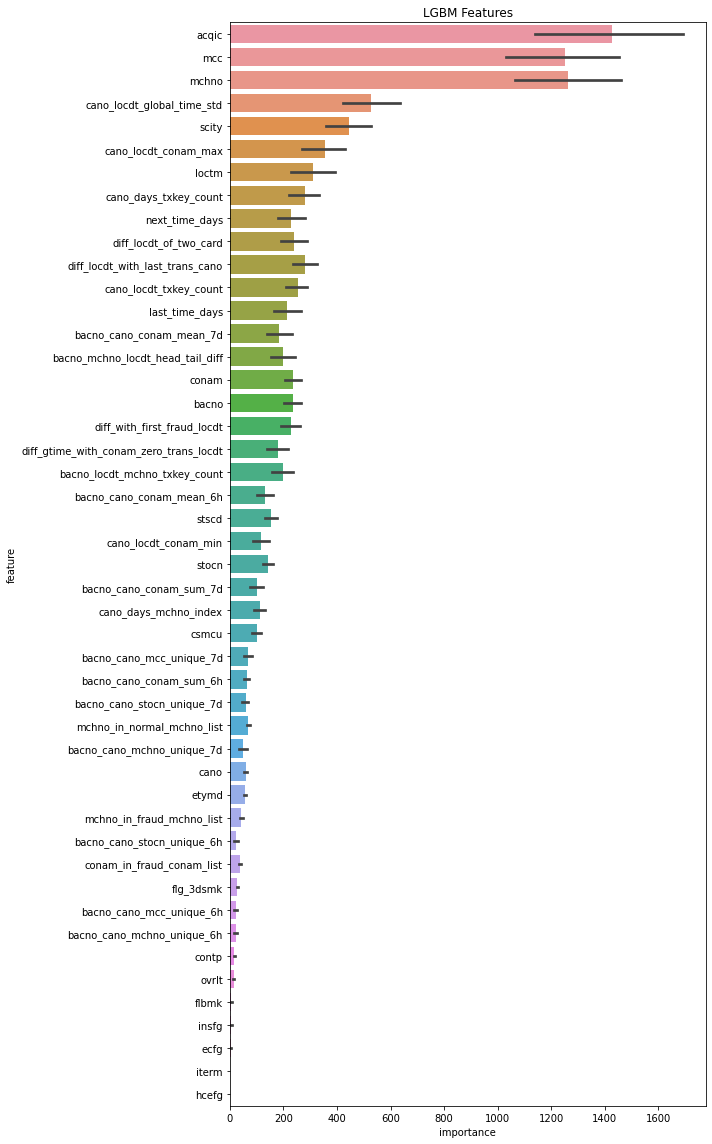

In [19]:
plot_importance(lgbm.df_feature_importance)

In [20]:
df_sub_preds_statistics = generate_statistic(df_sub_preds_LGBM)
df_sub_preds_statistics['mean_remove_outlier'] = df_sub_preds_statistics.apply(remove_outlier, axis = 1)
df_train['oof_both_exist_model'] = oof_preds_LGBM
df_test['sub_both_exist_model'] = df_sub_preds_statistics['mean_remove_outlier']

## Create Submission

In [21]:
threshold = 0.36

# Use base model for default
df_test['fraud_ind'] = np.where(df_test['sub_base_model']> threshold, 1, 0)
df_test['fraud_ind'] = np.where((df_test['bacno'].isin(both_in_train_test)) & (df_test['sub_both_exist_model'] > threshold), 1, df_test['fraud_ind'])


In [22]:
df_test[['txkey','fraud_ind']].to_csv('sub_{}.csv'.format(threshold),index = False)